# 遗传算法求解TSP问题

在用基于DEAP设计的遗传算法求解函数极值后，我们想要进一步解决一些更加困难点的问题。TSP问题就是很好的实验算法的舞台。本文将会介绍以下内容：

+ TSP问题的定义与运用遗传算法求解
+ 对比遗传算法与贪心算法及其改进型在用时和精确度两方面的表现
+ 探讨可能的改进方向

# TSP问题简介
旅行商问题（Traveling Salesman Problem(TSP)）描述：
> 给出n个不同的城市$\{ c_1, c_2, c_3, ..., c_n \}$以及城市两两之间的距离$d(c_i, c_j), i,j\in[1,n]$，求一个商人从某个城市出发，走遍所有城市并回到起点所需要经过的路径总距离为多少？

即求解一个路径（也即城市的排列）$r=\{c_{r1}, c_{r2}, ..., c_{rn}\}$，使得$[\sum\limits_{i=1}^{n-1}d(c_{ri},c_{ri+1})]+d(c_{rn},c_{r1})$取最小值

如果对两个城市$c_i,c_j$有$d(c_i,c_j)=d(c_j,c_i)$，那该问题被称为对称旅行商问题(Symmetric Traveling Salesman Problem(STSP))。否则就是非对称旅行商问题(ATSP)。

尽管描述很简单，TSP问题是一个非常经典而重要的问题：

+ 自从1930年代 Merrill M.Flood在学界引起了对该问题的重视以来，学者们已经从图论、组合优化、线性规划等不同角度对该问题进行了深入广泛的研究。
+ TSP问题的一个特殊性在于它必然存在可以找到的最优解（通过穷举法一定能在时间内找到该最优解），但是在计算复杂度方面它是一个经典的NP-hard问题。因而快速有效寻找TSP的最优解仍然是个有吸引力的问题。
+ 在实际应用方面，它可以被视为物流调度，交通规划，芯片布线优化等等问题的抽象简化。


# TSP问题的遗传算法（GA）求解
通过之前对DEAP的解读，我们很容易就能基于该框架，写出一个求解TSP问题的GA算法。在TSPLib上测试该算法之前，我们先在随机生成的数据集上进行测试与改进：


In [1]:
## 环境设置
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.spatial import distance
from deap import creator, base, tools, algorithms
import random

params = {
    'font.family': 'serif',
    'figure.figsize': [4.0, 3.0],
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'legend.fontsize': 'small'
}
plt.rcParams.update(params)
#--------------------------------
## 定义TSP中的基本元素

# 用[n,2]的np.array存储城市坐标；每行存储一个城市
def genCity(n, Lb = 100 ,Ub = 999):
    """
    生成城市坐标
    :param: n 需要生成的城市数量
    :param: Lb, Ub 坐标X、Y的上下限
    :return: n x 2 np array 每行是一个城市的[X,Y]坐标
    """
    np.random.seed(42) # 保证结果的可复现性
    return np.random.randint(low = Lb, high = Ub, size=(n,2))

# 计算并存储城市距离矩阵
def cityDistance(cities):
    """
    生成城市距离矩阵 distMat[A,B] = distMat[B,A]表示城市A，B之间距离
    :param：cities [n,2] np array， 表示城市坐标
    :return：n x n np array， 存储城市两两之间的距离
    """
    return distance.cdist(cities, cities, 'euclidean')

def completeRoute(individual):
    # 序列编码时，缺少最后一段回到原点的线段
    return individual + [individual[0]] # 不要用append
    
# 通过查表计算给定路线的长度，该函数将充当评价函数
def routeDistance(route):
    """
    :param：route -- 一条路线，一个sequence
    :return：routeDist -- scalar，路线的长度
    
    """
    if route[0] != route[-1]:
        route = completeRoute(route)
    routeDist = 0
    for i,j in zip(route[0::],route[1::]):
        routeDist += cityDist[i,j] # 这里直接从cityDist变量中取值了，其实并不是很安全的写法，单纯偷懒了
    return (routeDist), # 注意DEAP要求评价函数返回一个元组

# 路径可视化
def plotTour(tour, cities, style = 'bo-'):
    if len(tour)>1000: plt.figure(figsize = (15,10))
    start = tour[0:1]
    for i,j in zip(tour[0::], tour[1::]):
        plt.plot([cities[i,0],cities[j,0]], [cities[i,1],cities[j,1]], style)
    plt.plot(cities[start,0],cities[start,1],'rD')
    plt.axis('scaled')
    plt.axis('off')
    
#--------------------------------
## 设计GA算法
nCities = 30
cities = genCity(nCities) # 随机生成nCities个城市坐标

# 问题定义
creator.create('FitnessMin', base.Fitness, weights=(-1.0,)) # 最小化问题
creator.create('Individual', list, fitness=creator.FitnessMin)

# 定义个体编码
toolbox = base.Toolbox()
toolbox.register('indices', random.sample, range(nCities), nCities) # 创建序列
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indices)

# 生成族群
N_POP = 100
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
pop = toolbox.population(N_POP)

# 注册所需工具
cityDist = cityDistance(cities)
toolbox.register('evaluate', routeDistance)
toolbox.register('select', tools.selTournament, tournsize = 2)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.2)

# 数据记录
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register('avg', np.mean)
stats.register('min', np.min)

# 调用内置的进化算法
resultPop, logbook = algorithms.eaSimple(pop, toolbox, cxpb = 0.5, mutpb = 0.2, ngen = 300, stats = stats, verbose = True)

gen	nevals	avg    	min    
0  	100   	14214.2	11430.2
1  	50    	13767.6	11768  
2  	57    	13529.3	11486.5
3  	64    	13326.8	11375.6
4  	60    	13209.3	11344.7
5  	55    	13017.5	11344.7
6  	63    	13025.2	10899.3
7  	47    	12889.6	10899.3
8  	57    	12836.2	10899.3
9  	61    	12631.4	10442.9
10 	62    	12601.3	10624  
11 	48    	12445.2	10624  
12 	49    	12272.6	10624  
13 	56    	12149.8	10086.4
14 	65    	12283.1	10235.8
15 	65    	12042.6	9662.1 
16 	55    	11997  	9662.1 
17 	56    	12030.1	9662.1 
18 	59    	11833.3	9790.39
19 	44    	11862.3	9387.34
20 	63    	11814.9	9387.34
21 	60    	11605.8	9387.34
22 	58    	11429.7	9387.34
23 	57    	11420.2	9469.05
24 	61    	11226.1	8936.28
25 	60    	11314.4	9478.87
26 	62    	11165.1	9087.02
27 	63    	11179.7	8574.58
28 	59    	11132.1	7823.41
29 	61    	11124.9	7823.41
30 	70    	11170.2	7823.41
31 	51    	10897.4	7678.67
32 	53    	10694  	7823.41
33 	61    	10585  	7823.41
34 	66    	10656.1	7823.41
35 	63    	10638.9	7823.41
3

对结果进行可视化：

最优路径为:[5, 16, 2, 14, 7, 0, 15, 8, 25, 27, 23, 24, 18, 1, 29, 22, 13, 20, 21, 17, 6, 10, 11, 12, 4, 19, 9, 3, 28, 26, 5]
最优路径距离为：(5811.070500534853,)


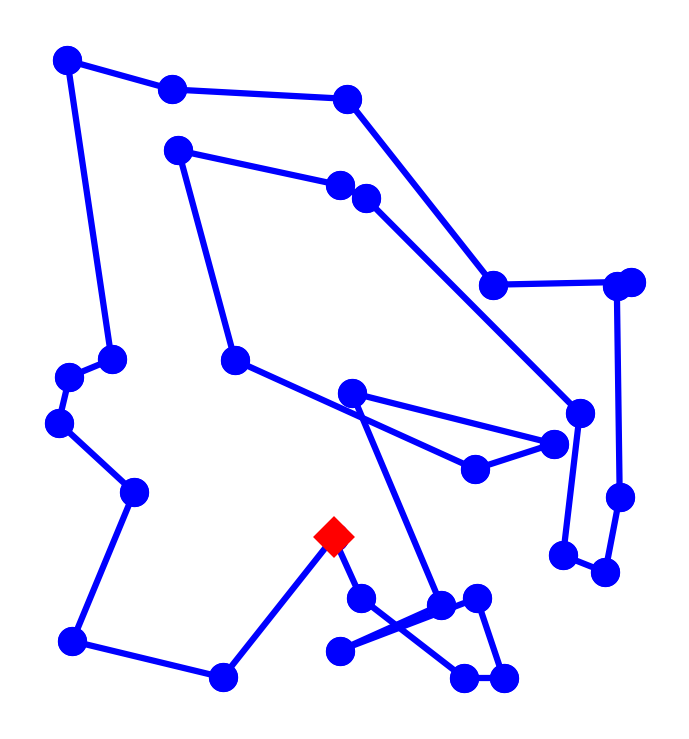

In [2]:
tour = tools.selBest(resultPop, k=1)[0]
tourDist = tour.fitness
tour = completeRoute(tour)
print('最优路径为:'+str(tour))
print('最优路径距离为：'+str(tourDist))
plotTour(tour, cities)

# 算法对比与分析

## 最近邻算法：nn TSP
穷举法能够保证求出TSP问题的最优解，但是其耗时会随着问题规模的扩大而剧增。其复杂度为O(n!)，是不能接受的。

而在应用于实际时，TSP问题的规模往往成千上万，用穷举法求解显然不现实，因此我们需要更加有效的求解方法。

在考虑问题时，一般算法设计的策略有以下几种:

+ 暴力破解：列出所有可能性，一一尝试并最终给出答案；
+ 近似算法：如果问题的最优解或准确解很难给出，那么可以尝试找出问题的次优解或近似解；
+ 贪心算法：对于多步骤算法，可以在每一步都取局部最优，并重复直到问题解决；
+ 迭代算法：用一个算法求解，另一个算法来提升解的有效性；
+ 集合算法：在算法集中准备一系列算法，依次尝试并取最好结果；
+ 分而治之：讲一个问题划分为一系列子问题，依次求解后组合成最后结果；
+ 站在巨人肩膀上：参考已有算法（just google it!）。

最近邻算法就是同时包含了近似算法和贪心算法思想的一种算法。用于求解TSP问题时，nnTSP可以描述为：

+ 从某个城市出发；
+ 移动到离现在所处城市最近的且没有访问过的邻居去；

实现：


nnTSP寻找到的最优路径为：[0, 15, 7, 14, 2, 16, 19, 26, 5, 4, 9, 28, 3, 22, 29, 1, 11, 13, 10, 12, 6, 21, 20, 27, 25, 17, 8, 23, 18, 24, 0]
nnTSP寻找到最优路径长度为：5156.612343174932


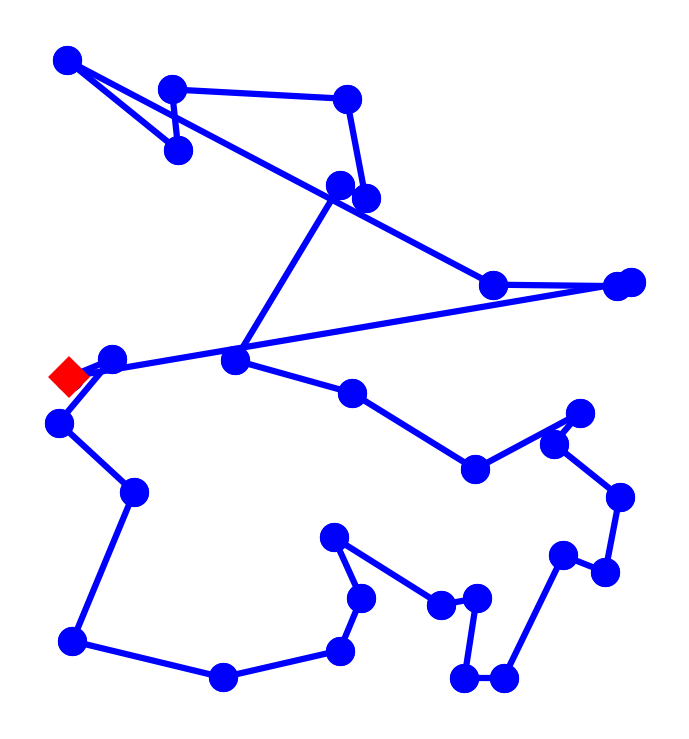

In [3]:
# 在未访问列表中寻找当前位置的最近邻
def nearestNeighbor(cityDist, currentPos, unvisited):
    # 输入：cityDist -- [n,n] np array,记录城市间距离
    # currentPos -- 一个数字，指示当前位于的城市
    # unvisited -- 一个列表，指示可选邻居列表
    # 输出：
    # nextToVisit -- 一个数字，给出最近邻的index
    # dist -- 一个数字，给出到最近邻的距离
    neighborDist = cityDist[currentPos,unvisited]
    neighborIdx = np.argmin(neighborDist)
    nextToVisit = unvisited[neighborIdx]
    dist = neighborDist[neighborIdx]
    return nextToVisit, dist

# 用贪婪算法求解TSP
def nnTSP(cities, start = 0):
    cityList = list(range(cities.shape[0]))
    tour = [start]
    unvisited = cityList.copy()
    unvisited.remove(start)
    currentPos = start
    tourDist = 0
    cityDist = cityDistance(cities)
    while unvisited:
        # 当unvisited集合不为空时，重复循环
        # 找到当前位置在unvisited中的最近邻
        nextToVisit, dist = nearestNeighbor(cityDist, currentPos, unvisited)
        tourDist += dist
        currentPos = nextToVisit
        tour.append(nextToVisit)
        unvisited.remove(nextToVisit)
    # 重新回到起点
    tour.append(start)
    tourDist += cityDist[currentPos, start]
    return tour,tourDist

tour_nntsp,tourDist = nnTSP(cities)
print('nnTSP寻找到的最优路径为：' + str(tour_nntsp))
print('nnTSP寻找到最优路径长度为：' + str(tourDist))
plotTour(tour_nntsp, cities)

## repNNTSP
从nnTSP的算法设计上可以看到，该算法求出的最优路径是和起点相关的，对于不同的起点，会产生不同的最优路径。因而一个简单的改进思路是我们以每个城市为起点进行一次nnTSP搜索，然后在所有得到的路线中选取最优的。

代码实现如下：

repNNTSP寻找到的最优路径为：[20, 21, 27, 25, 17, 8, 15, 0, 7, 14, 2, 16, 19, 26, 5, 4, 9, 28, 3, 22, 29, 1, 11, 13, 10, 12, 6, 23, 18, 24, 20]
repNNTSP寻找到最优路径长度为：4529.115576833992


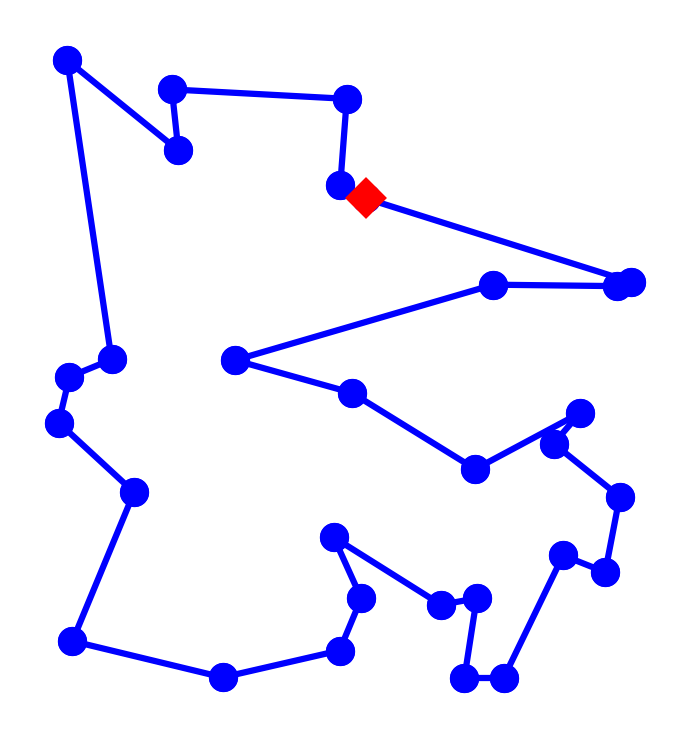

In [4]:
# 重复nnTSP但是每次用不同的起点，挑选最佳的结果
def repNNTSP(cities):
    optimizedRoute = [] # 最优路径
    minDistance = np.Inf # 最优路径长度
    for i in range(len(cities)):
        tour,tourDist = nnTSP(cities, start = i)
        if tourDist < minDistance:
            optimizedRoute = tour
            minDistance = tourDist
    return optimizedRoute, minDistance

tour_repnntsp,tourDist = repNNTSP(cities)
print('repNNTSP寻找到的最优路径为：' + str(tour_repnntsp))
print('repNNTSP寻找到最优路径长度为：' + str(tourDist))
plotTour(tour_repnntsp, cities)

## 2-OPT
在nnTSP给出的结果中，包含了一些交叉。这些交叉会导致路径长度的增加：

![](https://upload-images.jianshu.io/upload_images/17867674-b87fdbadae79ac0c.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/372/format/webp)

可以看到当出现X交叉时，从三角不等式可知，两根红线表示的长度一定小于两根蓝线，故而解开这样的交叉一定能减少路径长度。

我们可以考虑运用迭代思想，在使用nnTSP得到一条可行的路径之后，对路径进行优化，从而得到比nnTSP更优，同时比穷举法更快的解法。
这里我们可以在nnTSP建立了可行路径之后，选用2-Opt作为优化算法，其步骤为：

+ 设路径$route$长度为$n$，选择起点$i\in[1, n-3]$和终点$j\in[i+2, n-1]$；
+ 对位于$i,j$之间的子路径$route[i:j]$进行反转；
+ 如果翻转后的路径较优，将其设置为最优路径

nnTSP + 2OPT优化后的最优路径为：[0, 15, 7, 14, 2, 16, 19, 26, 5, 4, 9, 28, 3, 22, 29, 1, 11, 13, 10, 12, 24, 18, 23, 8, 17, 25, 27, 20, 21, 6, 0]
nnTSP + 2OPT优化后的最优路径长度为：(4847.935437722887,)


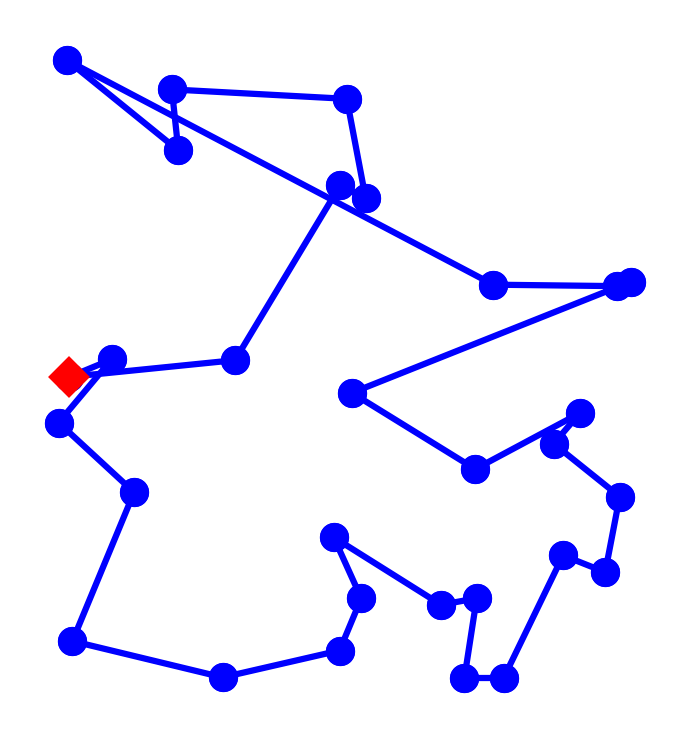

In [5]:
# 2OPT
def opt(cityDist, route, k=2):
    # 用2-opt算法优化路径
    # 输入：cityDist -- [n,n]矩阵，记录了城市间的距离
    # route -- sequence，记录路径
    # 输出： 优化后的路径optimizedRoute及其路径长度
    nCities = len(route) # 城市数
    optimizedRoute = route # 最优路径
    minDistance = routeDistance(route) # 最优路径长度
    for i in range(1,nCities-2):
        for j in range(i+k, nCities):
            if j-i == 1:
                continue
            reversedRoute = route[:i]+route[i:j][::-1]+route[j:]# 翻转后的路径
            reversedRouteDist = routeDistance(reversedRoute)
            # 如果翻转后路径更优，则更新最优解
            if  reversedRouteDist < minDistance:
                minDistance = reversedRouteDist
                optimizedRoute = reversedRoute
    return optimizedRoute, minDistance

optimizedRoute, minDistance = opt(cityDist, tour_nntsp)
print('nnTSP + 2OPT优化后的最优路径为：' + str(optimizedRoute))
print('nnTSP + 2OPT优化后的最优路径长度为：' + str(minDistance))
plotTour(optimizedRoute, cities)

可以看到在应用2-OPT之后，相比优化之前，路径长度减少了308.677；但是另一方面，通过简单的对sub-tour进行翻转并没有能完全uncross所有的交叉。

这个优化方法同样可以用于repNNTSP，来检查是否能找到更优解。用2-OPT迭代优化repNNTSP的代码:

repnnTSPtour + 2OPT优化后的最优路径为：[20, 21, 27, 25, 8, 17, 15, 0, 7, 14, 2, 16, 19, 26, 5, 4, 9, 28, 3, 22, 29, 1, 11, 13, 10, 12, 6, 23, 18, 24, 20]
repnnTSPtour + 2OPT优化后的最优路径长度为：(4479.933406593657,)


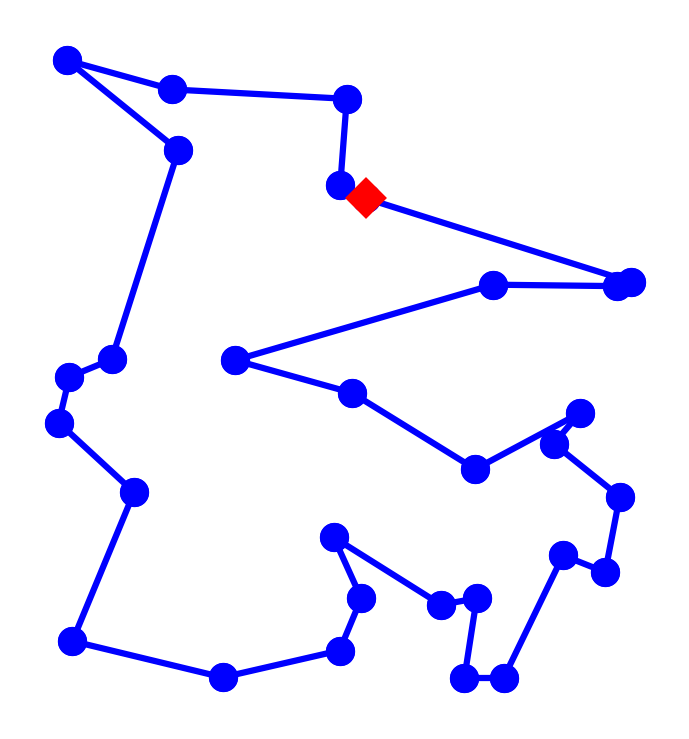

In [6]:
repnnTSPtourOptimized, repnnTSPtourDistOptimized = opt(cityDist, tour_repnntsp, 2)
print('repnnTSPtour + 2OPT优化后的最优路径为：' + str(repnnTSPtourOptimized))
print('repnnTSPtour + 2OPT优化后的最优路径长度为：' + str(repnnTSPtourDistOptimized))
plotTour(repnnTSPtourOptimized, cities)

# 算法对比

## 用时
|问题规模|	SGA|	nnTSP|	repNNTSP|	2-OPT
|---|---|---|---|---
|30	    |707 ms| 	0.142 ms| 	4.21 ms|	2.64 ms
|100	|1.76 s|	0.727 ms|	68.3 ms|	2.85 ms
|300	|4.71 s|	3.95 ms|	1.19 s|	2.87 ms
|500	|7.63 s|	9.6 ms|	4.86 s|	2.71 ms
|1000	|35.9 s|	34.7 ms|	15.2 s|	2.64 ms

<img src="https://upload-images.jianshu.io/upload_images/17867674-35cf521175b7c431.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/1200/format/webp" width="55%"/>

## 精度
由于遗传算法并非每次都能稳定收敛于一个值，此处列出的解是5次计算所得的均值

|问题规模|	SGA	|nnTSP|	repNNTSP|	nnTSP+2-OPT|	repNNTSP+2-OPT
|---|---|---|---|---|---
|30|$6015.37609\pm387.95984$|		5156.61234|	4529.11558|	4847.93543|	4479.93341
|100|$27458.49044\pm839.38469$|		9597.18163|	8664.28408|	9388.79648|	8532.54589
|300|$98258.73711\pm2088.89646$|		14958.54994|	14753.59721|	14033.02485|	13914.14821

为了在速度上稍有竞争力，只有200代迭代的情况下，SGA往往还没有收敛到最佳，波动还是相对较大的。但是规模问题越大，SGA收敛需要的迭代步数越多，强行在200步结束迭代的结果就是获取的解毫无竞争力。

# 小结

在随机生成的TSP问题中，我们的SGA基本上被其他算法吊打：

+ SGA需要的时间远大于nnTSP和repNNTSP；而且它对问题的规模更加敏感，在大规模问题上想要收敛到满意的解需要更多迭代步与更大的种群，这又会造成计算时间进一步增加；
+ 可能的改进方向之一是加入环境选择而不是用生成的子代完整替代父代，保证留下精英族群，来加速收敛；
+ 可能的改进方向之二是对种群规模、迭代步数、交叉和突变概率等超参数进行调参，以使算法在TSP问题上更快收敛，并且获得更好的结果；
+ 可能的改进方向之三在于利用问题特性，在SGA的基础上加入局部搜索算法，例如用2-OPT改善精英解；
+ 后续将会试着按照这三个方向进行SGA的改进。